Данные:
- Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
- Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
connection = {'host': '***',
                      'database':'***',
                      'user':'***', 
                      'password':'****'
                     }

In [3]:
query_group_0 = """
 SELECT distinct user_id, sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
 FROM {db}.feed_actions 
 WHERE toDate(time) >= '2023-01-01' and  toDate(time) <= '2023-01-07' 
     and exp_group in (0)
 GROUP BY user_id
 """

query_group_1 = """
 SELECT distinct user_id, sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
 FROM {db}.feed_actions 
 WHERE toDate(time) >= '2023-01-01' and  toDate(time) <= '2023-01-07' 
     and exp_group in (1)
 GROUP BY user_id
 """

query_group_2 = """
 SELECT distinct user_id, sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
 FROM {db}.feed_actions 
 WHERE toDate(time) >= '2023-01-01' and  toDate(time) <= '2023-01-07' 
     and exp_group in (2)
 GROUP BY user_id
 """

query_group_3 = """
 SELECT distinct user_id, sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
 FROM {db}.feed_actions 
 WHERE toDate(time) >= '2023-01-01' and  toDate(time) <= '2023-01-07' 
     and exp_group in (3)
 GROUP BY user_id
 """

df_group_0 = ph.read_clickhouse(query_group_0, connection=connection)
df_group_1 = ph.read_clickhouse(query_group_1, connection=connection)
df_group_2 = ph.read_clickhouse(query_group_2, connection=connection)
df_group_3 = ph.read_clickhouse(query_group_3, connection=connection)

In [6]:
def CTR_control(likes, views):
    CTRcontrol = sum(likes) / sum (views)
    return CTRcontrol

def lin_CTR(CTRcontrol, likes, views):
    lin_likes = likes - CTRcontrol * views
    return lin_likes

#### Исследование групп 0 и 3

In [22]:
CTR_control_g0 = CTR_control(df_group_0.likes, df_group_0.views)

In [27]:
lin_CTR_g3 = lin_CTR(CTR_control_g0, df_group_3.likes, df_group_3.views)
lin_CTR_g0 = lin_CTR(CTR_control_g0, df_group_0.likes, df_group_0.views)

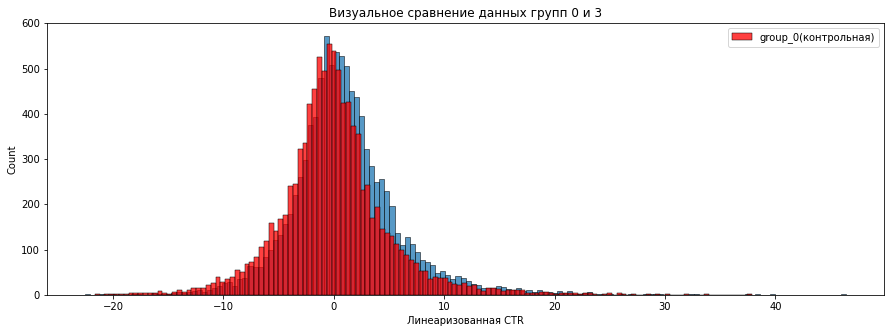

In [49]:
plt.figure(figsize=(15,5))
plt.title('Визуальное сравнение данных групп 0 и 3')
plt.xlabel('Линеаризованная CTR')
sns.histplot(lin_CTR_g3)
sns.histplot(lin_CTR_g0, label='group_0(контрольная)', color='red')
plt.legend(loc="best")


In [57]:
print('P-value t-теста для линеаризованных данных: {0}'.format(stats.ttest_ind(lin_CTR_g3, lin_CTR_g0, equal_var=False).pvalue))
print('P-value t-теста для исходных данных: {0}'.format(stats.ttest_ind(df_group_3.ctr, df_group_0.ctr, equal_var=False).pvalue))

P-value t-теста для линеаризованных данных: 5.4914249479690016e-52
P-value t-теста для исходных данных: 1.055849414662529e-43


Вывод:
- Значение p-value стало меньше. 

#### Исследование групп 1 и 2

In [37]:
CTR_control_g1 = CTR_control(df_group_1.likes, df_group_1.views)

In [38]:
lin_CTR_g1 = lin_CTR(CTR_control_g1, df_group_1.likes, df_group_1.views)
lin_CTR_g2 = lin_CTR(CTR_control_g1, df_group_2.likes, df_group_2.views)

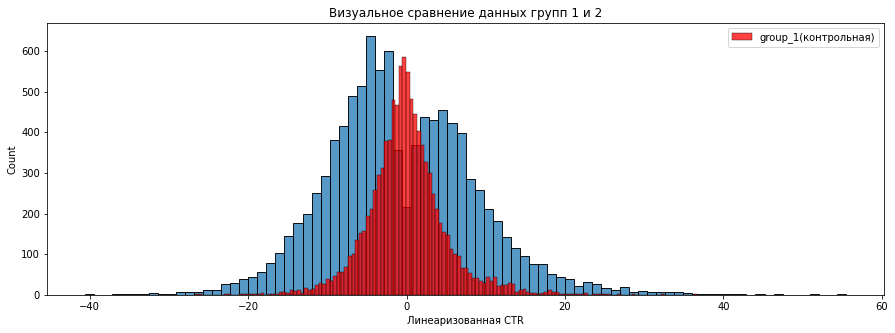

In [50]:
plt.figure(figsize=(15,5))
plt.title('Визуальное сравнение данных групп 1 и 2')
plt.xlabel('Линеаризованная CTR')
sns.histplot(lin_CTR_g2)
sns.histplot(lin_CTR_g1, label='group_1(контрольная)', color='red')
plt.legend(loc="best")

In [58]:
print('P-value t-теста для линеаризованных данных: {0}'.format(stats.ttest_ind(lin_CTR_g1, lin_CTR_g2, equal_var=False).pvalue))
print('P-value t-теста для исходных данных: {0}'.format(stats.ttest_ind(df_group_1.ctr, df_group_0.ctr, equal_var=False).pvalue))

P-value t-теста для линеаризованных данных: 9.439432187037712e-10
P-value t-теста для исходных данных: 0.47806231308750413


Вывод:
- значение p-value стало меньше (<< 0.05)
- разница между данными группы 1 и 2 стала статистически значимой. Вероятность получить такие же или еще более различия - мала, в предположении отсутствия разницы между данными.